# US COVID-19 Data

In [28]:
import os
import sys

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

import urllib
import zipfile
import glob

## Import data from NYTimes

The [New York Times](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) daily shares the latest update on COVID-19 in the US. They use various data visualization tools for easier understanding of the data.  They also share all of their data on [GitHub](https://github.com/nytimes/covid-19-data).

[![ne_download_page](https://raw.githubusercontent.com/katkim0307/COVID-19_Response_Comparison/master/Data/image/nytimes_cov19_page.PNG)](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html)

### Read in US, States, and Counties data

In [13]:
nytimes_us_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
nytimes_states_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes_counties_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

### US

In [98]:
nytimes_us_df = pd.read_csv(nytimes_us_url)

nytimes_us_df.tail()

date    cases  deaths
98   2020-04-28  1012572   53034
99   2020-04-29  1039166   55399
100  2020-04-30  1069559   57570
101  2020-05-01  1103544   59392
102  2020-05-02  1133083   61077

In [29]:
nytimes_us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    103 non-null    object
 1   cases   103 non-null    int64 
 2   deaths  103 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [32]:
nytimes_us_df['date']=pd.to_datetime(nytimes_us_df['date'])

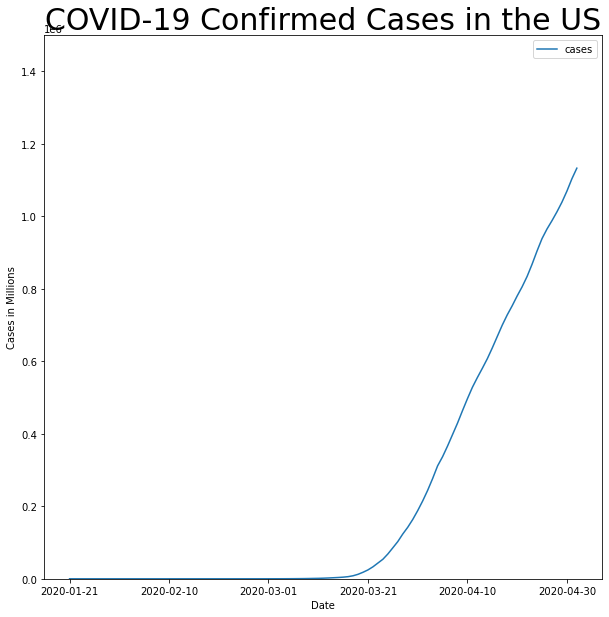

In [114]:
nytimes_us_df.plot(
    x='date',
    y='cases',
    kind='line',
    figsize=(10,10),
    ylim=(0, 1500000),
);

plt.title('COVID-19 Confirmed Cases in the US', fontdict={'size': 30})
plt.xlabel('Date')
plt.ylabel('Cases in Millions')
plt.show();

### States

In [36]:
nytimes_states_df = pd.read_csv(nytimes_states_url, dtype={'fips':object})

nytimes_states_df.head()

date       state fips  cases  deaths
0  2020-01-21  Washington   53      1       0
1  2020-01-22  Washington   53      1       0
2  2020-01-23  Washington   53      1       0
3  2020-01-24    Illinois   17      1       0
4  2020-01-24  Washington   53      1       0

In [37]:
nytimes_states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3369 entries, 0 to 3368
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3369 non-null   object
 1   state   3369 non-null   object
 2   fips    3369 non-null   object
 3   cases   3369 non-null   int64 
 4   deaths  3369 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 131.7+ KB


In [33]:
nytimes_states_df['date']=pd.to_datetime(nytimes_states_df['date'])

### Counties

In [39]:
nytimes_counties_df = pd.read_csv(nytimes_counties_url, dtype={'fips':object})

nytimes_counties_df.head()

date     county       state   fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061      1       0
1  2020-01-22  Snohomish  Washington  53061      1       0
2  2020-01-23  Snohomish  Washington  53061      1       0
3  2020-01-24       Cook    Illinois  17031      1       0
4  2020-01-24  Snohomish  Washington  53061      1       0

In [40]:
nytimes_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109696 entries, 0 to 109695
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    109696 non-null  object
 1   county  109696 non-null  object
 2   state   109696 non-null  object
 3   fips    108406 non-null  object
 4   cases   109696 non-null  int64 
 5   deaths  109696 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.0+ MB


In [34]:
nytimes_counties_df['date']=pd.to_datetime(nytimes_counties_df['date'])

## Import data from COVID-19 Tracking Project

The [COVID Tracking Project](https://covidtracking.com/) publishes the latest update on COVID-19 testing in the US and territories. They use various data visualization tools for easier understanding of the data.  [Download](https://covidtracking.com/api) their data at a national and state level.

[![ne_download_page](https://raw.githubusercontent.com/katkim0307/COVID-19_Response_Comparison/master/Data/image/cov_track_proj_page.PNG)](https://covidtracking.com/)

### Read in US Historical Data and States Historical Data

In [63]:
covtrack_us_hist_url = 'https://covidtracking.com/api/v1/us/daily.json'
covtrack_us_now_url = 'https://covidtracking.com/api/v1/us/current.json'

covtrack_states_hist_url = 'https://covidtracking.com/api/v1/states/daily.json'
covtrack_states_now_url = 'https://covidtracking.com/api/v1/states/current.json'

### US

In [53]:
covtrack_us_now_df = pd.read_json(covtrack_us_now_url)

covtrack_us_now_df

positive  negative  pending  hospitalizedCurrently  hospitalizedCumulative  \
0   1152006   5901360     2812                  50312                  125796   

   inIcuCurrently  inIcuCumulative  onVentilatorCurrently  \
0            9292             4502                   4761   

   onVentilatorCumulative  recovered  \
0                     425     180152   

                                       hash lastModified  death  hospitalized  \
0  d9bbf5d5083f4ac74e13a02578db56835078c70a     5/4/2020  61868        125796   

     total  totalTestResults   posNeg  \
0  7056178           7053366  7053366   

                                               notes  
0  NOTE: "total", "posNeg", "hospitalized" will b...

In [91]:
covtrack_us_hist_df = pd.read_json(covtrack_us_hist_url, dtype={'fips':object})

covtrack_us_hist_df.tail()

date  states  positive  negative  pending  hospitalizedCurrently  \
98   20200126       1         1       NaN      NaN                    NaN   
99   20200125       1         1       NaN      NaN                    NaN   
100  20200124       1         1       NaN      NaN                    NaN   
101  20200123       1         1       NaN      NaN                    NaN   
102  20200122       1         1       NaN      NaN                    NaN   

     hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
98                      NaN             NaN              NaN   
99                      NaN             NaN              NaN   
100                     NaN             NaN              NaN   
101                     NaN             NaN              NaN   
102                     NaN             NaN              NaN   

     onVentilatorCurrently  ...  death  hospitalized total totalTestResults  \
98                     NaN  ...    NaN           NaN     1                1   
99                     NaN  ...    NaN           NaN     1                1   
100                    NaN  ...    NaN           NaN     1                1   
101                    NaN  ...    NaN           NaN     1                1   
102                    NaN  ...    NaN           NaN     1                1   

     posNeg  deathIncrease  hospitalizedIncrease  negativeIncrease  \
98        1            0.0                   0.0               0.0   
99        1            0.0                   0.0               0.0   
100       1            0.0                   0.0               0.0   
101       1            0.0                   0.0               0.0   
102       1            NaN                   NaN               NaN   

     positiveIncrease  totalTestResultsIncrease  
98                0.0                       0.0  
99                0.0                       0.0  
100               0.0                       0.0  
101               0.0                       0.0  
102               NaN                       NaN  

[5 rows x 24 columns]

In [92]:
covtrack_us_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      103 non-null    int64  
 1   states                    103 non-null    int64  
 2   positive                  103 non-null    int64  
 3   negative                  65 non-null     float64
 4   pending                   61 non-null     float64
 5   hospitalizedCurrently     48 non-null     float64
 6   hospitalizedCumulative    44 non-null     float64
 7   inIcuCurrently            39 non-null     float64
 8   inIcuCumulative           40 non-null     float64
 9   onVentilatorCurrently     40 non-null     float64
 10  onVentilatorCumulative    33 non-null     float64
 11  recovered                 40 non-null     float64
 12  hash                      103 non-null    object 
 13  dateChecked               103 non-null    object 
 14  death     

In [93]:
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['date'].astype(str), format='%Y-%m-%d')

covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['datetime'])

covtrack_us_hist_df.tail()

date  states  positive  negative  pending  hospitalizedCurrently  \
98   20200126       1         1       NaN      NaN                    NaN   
99   20200125       1         1       NaN      NaN                    NaN   
100  20200124       1         1       NaN      NaN                    NaN   
101  20200123       1         1       NaN      NaN                    NaN   
102  20200122       1         1       NaN      NaN                    NaN   

     hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
98                      NaN             NaN              NaN   
99                      NaN             NaN              NaN   
100                     NaN             NaN              NaN   
101                     NaN             NaN              NaN   
102                     NaN             NaN              NaN   

     onVentilatorCurrently  ...  hospitalized  total totalTestResults posNeg  \
98                     NaN  ...           NaN      1                1      1   
99                     NaN  ...           NaN      1                1      1   
100                    NaN  ...           NaN      1                1      1   
101                    NaN  ...           NaN      1                1      1   
102                    NaN  ...           NaN      1                1      1   

     deathIncrease  hospitalizedIncrease  negativeIncrease  positiveIncrease  \
98             0.0                   0.0               0.0               0.0   
99             0.0                   0.0               0.0               0.0   
100            0.0                   0.0               0.0               0.0   
101            0.0                   0.0               0.0               0.0   
102            NaN                   NaN               NaN               NaN   

     totalTestResultsIncrease   datetime  
98                        0.0 2020-01-26  
99                        0.0 2020-01-25  
100                       0.0 2020-01-24  
101                       0.0 2020-01-23  
102                       NaN 2020-01-22  

[5 rows x 25 columns]

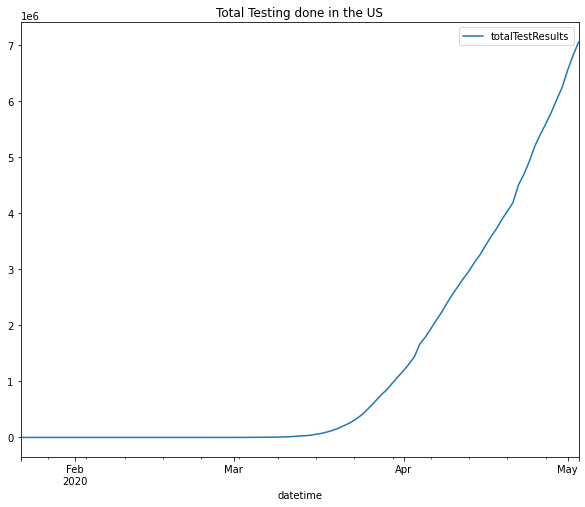

In [100]:
covtrack_us_hist_df.plot(
    x='datetime',
    y='totalTestResults',
    title='Total Testing done in the US',
    figsize=(10, 8),
);

In [95]:
covtrack_us_hist_plot = covtrack_us_hist_df[['datetime', 'positive', 'death', 'total']]
covtrack_us_hist_plot.set_index('datetime', inplace=True)

In [101]:
# plot data
fig, ax = plt.subplots(figsize=(10, 8))
covtrack_us_hist_plot.plot(ax=ax)

# set ticks every month
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# set the time limit
ax.set_xlim(['2020-1-21', '2020-3-31'])
ax.set_ylim(0, 200000)

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### States

In [64]:
covtrack_states_now_df = pd.read_json(covtrack_states_now_url)

covtrack_states_now_df.head()

state  positive  positiveScore  negativeScore  negativeRegularScore  \
0    AK       368            1.0            1.0                   1.0   
1    AL      7725            1.0            1.0                   0.0   
2    AR      3431            1.0            1.0                   1.0   
3    AZ      8640            1.0            1.0                   0.0   
4    CA     53616            1.0            1.0                   0.0   

   commercialScore grade  score  \
0              1.0     A    4.0   
1              1.0     B    3.0   
2              1.0     A    4.0   
3              1.0     B    3.0   
4              1.0     B    3.0   

                                               notes dataQualityGrade  ...  \
0  Please stop using the "total" field. Use "tota...                C  ...   
1  Please stop using the "total" field. Use "tota...                B  ...   
2  Please stop using the "total" field. Use "tota...                B  ...   
3  Please stop using the "total" field. Use "tota...               A+  ...   
4  Please stop using the "total" field. Use "tota...                B  ...   

   checkTimeEt  death  hospitalized   total  totalTestResults  posNeg  fips  \
0   5/03 15:41      9           NaN   21578             21578   21578     2   
1   5/03 16:15    290        1035.0   92500             92500   92500     1   
2   5/03 16:09     76         427.0   52890             52890   52890     5   
3   5/03 15:51    362        1348.0   81119             81119   81119     4   
4   5/03 15:54   2215           NaN  715751            715751  715751     6   

           dateModified           dateChecked  \
0  2020-05-03T18:15:00Z  2020-05-03T19:41:00Z   
1  2020-05-03T04:00:00Z  2020-05-03T20:15:00Z   
2  2020-05-03T17:30:00Z  2020-05-03T20:09:00Z   
3  2020-05-03T04:00:00Z  2020-05-03T19:51:00Z   
4  2020-05-03T18:00:00Z  2020-05-03T19:54:00Z   

                                       hash  
0  ecb32a99bc999e3ca2367609b91f421c7b38fc68  
1  3ac1545011b9e91fad4d49a68ec9922face23d81  
2  af90698007198f92469ad41b4397a72eaab43b98  
3  e19531e63c8cff46c64d413079f65cb161535887  
4  7e44599df4c3ba9deb196535fc0e2cbc88e3ed46  

[5 rows x 30 columns]

In [35]:
covtrack_states_now_df.shape

(56, 30)

In [1]:
covtrack_states_hist_df = pd.read_json(covtrack_states_hist_url, dtype={'fips':object})

covtrack_states_hist_df.head()

NameError: name 'pd' is not defined

In [70]:
covtrack_states_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      3321 non-null   int64  
 1   state                     3321 non-null   object 
 2   positive                  3306 non-null   float64
 3   negative                  3140 non-null   float64
 4   pending                   677 non-null    float64
 5   hospitalizedCurrently     1191 non-null   float64
 6   hospitalizedCumulative    1239 non-null   float64
 7   inIcuCurrently            594 non-null    float64
 8   inIcuCumulative           232 non-null    float64
 9   onVentilatorCurrently     471 non-null    float64
 10  onVentilatorCumulative    72 non-null     float64
 11  recovered                 1037 non-null   float64
 12  hash                      3321 non-null   object 
 13  dateChecked               3321 non-null   object 
 14  death   

In [71]:
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['date'].astype(str), format='%Y-%m-%d')

covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['datetime'])

covtrack_states_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      3321 non-null   int64         
 1   state                     3321 non-null   object        
 2   positive                  3306 non-null   float64       
 3   negative                  3140 non-null   float64       
 4   pending                   677 non-null    float64       
 5   hospitalizedCurrently     1191 non-null   float64       
 6   hospitalizedCumulative    1239 non-null   float64       
 7   inIcuCurrently            594 non-null    float64       
 8   inIcuCumulative           232 non-null    float64       
 9   onVentilatorCurrently     471 non-null    float64       
 10  onVentilatorCumulative    72 non-null     float64       
 11  recovered                 1037 non-null   float64       
 12  hash                